# DENMARK INTERNATIONAL TRADE

## 1. Import packages

In [1]:
import datetime as dt 
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader 
import pydst 

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 2. Read and clean data

### 2.1 Data on total external trade in goods and services

We start by reading the goods trade data in the excel file ``TRDG.xlsx``. Afterwards, we clean the file by removing and renaming columns and rows and changing the cell values of certain columns.

In [2]:
#a. Loading and removing the first two rows when reading
imp = pd.read_excel('TRDG.xlsx', skiprows = 2) 

#b. Dropping columns
drops = ['Unnamed: 0', 'Unnamed: 1'] 
imp.drop(drops, axis=1, inplace=True) #axis = 1: columns, inplace=True: changed, no copy made

#c. Renaming columns and cells
imp.rename(columns = {'Unnamed: 2':'Flow'}, inplace=True) #renaming the column 'Unnamed: 2' to 'Flow'
imp.loc[imp.Flow == 'Imports', 'Flow'] = 'Goods total imports' #renaming the cell import under column 'Flow' with 'Goods total imports'
imp.loc[imp.Flow == 'Exports', 'Flow'] = 'Goods total exports' #renaming the cell import under column 'Flow' with 'Goods total exports'

We read the service trade data in the excel file ``TRDS.xlsx``. As before we clean the file by removing and renaming columns and rows and changing the cell values of certain columns:

In [3]:
#a. Loading the data and removing the first two rows 
imps = pd.read_excel('TRDS.xlsx', skiprows = 2)

#b. Dropping columns
drops = ['Unnamed: 0', 'Unnamed: 1']
imps.drop(drops, axis=1, inplace=True) 

#c. Renaming columns and cell
imps.rename(columns = {'Unnamed: 2':'Flow'}, inplace=True)
imps.loc[imps.Flow == 'Imports', 'Flow'] = 'Services total imports'
imps.loc[imps.Flow == 'Exports', 'Flow'] = 'Services total exports'

We can now create a dataframe with both the data of goods and services imports and exports. Our final purpose is to plot their trends in the same graph. Subsequently, we transpose the obtained dataframe and we set the quarters as the new index. We trasform the quarters from object into date type through the general function *pd.to_datetime* and we delete the index name so that it will not appear in the legend of the plot.

In [4]:
#d. Merging the two dataset through the concat method
int_tr = pd.concat([imp,imps], axis=0, ignore_index=True)  

#e. Transposing the new dataframe and setting column 'Flow' as index
int_tr1 = int_tr.set_index('Flow').T

#f. Changing index data type from object to datetime and removing his name
int_tr1.index = pd.to_datetime(int_tr1.index)
del int_tr1.index.name

In [5]:
#### 2.2.1 Balance of trade

We now calculate the overall Balance of Trade. First of all, we need to calculate the total amount of exports and imports and only after their difference.

In [6]:
#a. Summing imports and exports
int_tr2 = int_tr1.copy()
int_tr2['total_exports'] = int_tr2['Goods total exports']+int_tr2['Services total exports']
int_tr2['total_imports'] = int_tr2['Goods total imports']+int_tr2['Services total imports']

#b. Calculating the difference
int_tr2['balance_of_trade'] = int_tr2['total_exports']-int_tr2['total_imports']

### 2.2 Data on trade partners in goods imports and exports

#### 2.2.1 Exports data

We read the excel file ``TRDC.xlsx`` and remove unnecessary rows. We clean the obtained dataset by removing and renaming columns and rows and changing the cell values of certain columns for simplicity reasons.

In [7]:
#a. Loading the data and removing the first two rows
tr_par = pd.read_excel('tradecountries.xlsx', skiprows = [0,1,3,14])

#b. Dropping columns
to_drop = ['Unnamed: 0']
tr_par.drop(to_drop, axis=1, inplace=True) # axis = 1 -> columns, inplace=True -> changed, no copy made

#c. Renaming columns and cells values
tr_par.rename(columns = {'Unnamed: 1':'impexp','Unnamed: 2':'Country'}, inplace=True)
d = {'Imports (excl. vessels and aircraft, fuels etc.)':'Imports','Exports (excl. vessels and aircraft, fuels etc.)':'Exports'}
tr_par1 = tr_par.replace(d)

As we only want the exports data, we select in the column *impexp* the rows with value **Export**. We make a copy of the resulting dataframe and remove the column *impexp* as it is not useful anymore.

In [8]:
#d. Selecting rows with 'Exports' value
tr_par2 = tr_par1.loc[tr_par1['impexp'] == 'Exports']

#e. Making a copy and removing column 'impexp'
tr_par3 = tr_par2.copy()
to_drp = ['impexp']
tr_par3.drop(to_drp, axis=1, inplace=True)

Before transposing the dataframe to plot the data, we want to get rid of the standard *[0,...,n] index*. Afterwards, as our analysis is concentrated during the period 2005-2019, we select data collected after January 2005 and we remove the last observation of January 2020 .

In [9]:
#f. Changing index and removing name
tr_par3.set_index('Country',inplace=True)
tr_par3.index.name = None

#g. Transposing the dataframe and changing index name
tr_par4 = tr_par3.transpose()
tr_par4.index.name = 'Date'

#h. Selecting data
tr = tr_par4.iloc[96:]
tr.reset_index(inplace=True)
tr1 = tr.drop(tr.index[180])

As we want to realize a stacked bar graph to detect the volume exchanged with each country we need to create two new columns *Other EU countries* and *Other non-EU countries* and to delete the previous columns *EU* and *World outside EU* which incorporate values of other columns. Finally, we convert *Date* column from object to date type.

In [10]:
#i. Creating new columns as result of algebraic calculations 
tr2 = tr1.copy()
tr2['Other EU countries'] = tr2['EU'] - tr2.iloc[:,2:7].sum(axis=1)
tr2['Other non-EU countries'] = tr2['World outside EU'] - tr2.iloc[:,8:11].sum(axis=1)

#j. Removing unnecessary columns
drop = ['EU','World outside EU']
tr3 = tr2.drop(drop, axis=1, inplace=False)

#k. Converting into date type and setting 'Date' column as index
tr3['Date'] =  pd.to_datetime(tr3['Date'], format='%YM%m')
tr3 = tr3.set_index('Date')

Our final purpose is to construct a stacked bar chart that show the relative importance of every trade partner for each year in our period of interest. So, firstly, we merge our monthly observations into annual observations and we construct a function that does the job (this function will be used later as well). Afterwards we calculate relative percentages with respect to the sum of values for each row.

In [11]:
#l. Function to merge monthly observations into annual observations
def convert_to_annual(df):
    """Aggregate 12 months of data into an annual value"""
    oth_col = df.columns
    i_col = [x for x in df.columns if x not in oth_col]
    df_up = df.resample('Y', kind = 'period')[oth_col].sum()
    df_up.index = df_up.index
    df_up[i_col] = df[i_col]  
    return df_up

tr3 = convert_to_annual(tr3)

#m. Calculating relative percentages 
tr3_perc = tr3.divide(tr3.sum(axis=1), axis=0)

# Sample of resulting dataframe
tr3_perc.head(3)

,Germany,Sweden,United Kingdom,Netherlands,France,Norway,USA,China,Other EU countries,Other non-EU countries
Date,,,,,,,,,,
2005,0.175522,0.109897,0.089917,0.040521,0.048993,0.058555,0.069189,0.015048,0.206745,0.185612
2006,0.173919,0.112631,0.084713,0.042275,0.050283,0.058603,0.068728,0.015159,0.215827,0.177862
2007,0.168107,0.117062,0.078148,0.043488,0.046628,0.062223,0.067436,0.019758,0.218798,0.178352


#### 2.2.2 Imports data

We basically perform exactly the same steps as we did for the export case. The excel file is the same as before but as we want now the imports data, we select in the column *impexp* the rows with value **Imports**.

In [12]:
#d. Selecting rows with 'Imports' value
tr_imp = tr_par1.loc[tr_par1['impexp'] == 'Imports']

#e. Making a copy and removing column 'impexp'
tr_imp1 = tr_imp.copy()
to_drp = ['impexp']
tr_imp1.drop(to_drp, axis=1, inplace=True)

#f. Changing index and removing name
tr_imp1.set_index('Country',inplace=True)
tr_imp1.index.name = None

#g. Transposing the dataframe and changing index name
tr_imp2 = tr_imp1.transpose()
tr_imp2.index.name = 'Date'

#h. Selecting data
trimp = tr_imp2.iloc[96:]
trimp.reset_index(inplace=True)
trimp1 = trimp.drop(tr.index[180])

#i. Creating new columns as result of algebraic calculations 
trimp2 = trimp1.copy()
trimp2['Other EU countries'] = trimp2['EU'] - trimp2.iloc[:,2:7].sum(axis=1)
trimp2['Other non-EU countries'] = trimp2['World outside EU'] - trimp2.iloc[:,8:11].sum(axis=1)

#j. Removing unnecessary columns
drop = ['EU','World outside EU']
trimp3 = trimp2.drop(drop, axis=1, inplace=False)

#k. Converting into date type and setting 'Date' column as index
trimp3['Date'] =  pd.to_datetime(trimp3['Date'], format='%YM%m')
trimp3 = trimp3.set_index('Date')

#l. Merge monthly observations into annual observations
trimp3 = convert_to_annual(trimp3)

#m. Calculating relative percentages 
trimp3_perc = trimp3.divide(trimp3.sum(axis=1), axis=0)

### 3. Data on exports and imports by type of goods

#### 3.1 Exports by type of goods data

We download the data directly though the API of Statistics Denmark. The subject we are interested in is the number *13: External Economy* and the precise table is *UHV1*.

In [13]:
#a. Loading data through the Statistics Denmark API in English
Dst = pydst.Dst(lang='en') 
Dst.get_subjects()

#b. Selecting subject and table
tables = Dst.get_tables(subjects=['13'])
tables[tables.id == 'UHV1']
ind_vars = Dst.get_variables(table_id='UHV1')

We extract the data that we want to work with. We select *INDUD: 2* and *SÆSON: SÆSON* because we want seasonally adjusted exports data and we download all the information regarding the type of goods *(ART)* and monthly observation *(Tid)*. Subsequently, we start cleaning and preparing the dataframe for Section 4. We drop and rename colums and we trasform monthly dates from subject into datetime type.

In [14]:
#c. Selecting data
var = {'INDUD':['2'],'SÆSON':['SÆSON'],'ART':['*'],'Tid':['*']}
gdr= Dst.get_data(table_id = 'UHV1', variables=var)

#. Sample of the dataframe downloaded
gdr.head(3)

,INDUD,SÆSON,ART,TID,INDHOLD
0,Exports,Seasonally adjusted,"Vessels, aircraft etc.",2019M06,659.0
1,Exports,Seasonally adjusted,TOTAL,2019M06,61246.4
2,Exports,Seasonally adjusted,"TOTAL (excl. vessels, aircraft, fuels etc.)",2019M06,57638.1


In [15]:
#d. Renaming and deleting columns and rows
gdr.rename(columns = {'INDUD':'ImpExp','ART':'Type of good','TID':'Date','INDHOLD':'Values'}, inplace=True)
to_drop = ['ImpExp','SÆSON']
gdr.drop(to_drop, inplace=True, axis=1)
gdr.drop(gdr.index[2])

#e. Changing type
gdr['Date'] =  pd.to_datetime(gdr['Date'], format='%YM%m')

We now structure the dataframe to have the monthly dates as our index rows and the various goods types as our columns through the *pivot* method. Afterwords we remove columns that will not be useful for our analysis. As we are interested in the period 2005-2019, we select only data referring to this period of time.

In [16]:
#f. Structuring dataframe 
gdr1 = gdr.pivot(index='Date', columns='Type of good', values='Values')

# Sample of the obtained dataframe
gdr1.head(3)

Type of good,Chemicals And Related Products,"Crude Materials, Inedible, Except Fuels","Live animals, Food, Beverages And Tobacco",Machinery (excl. Transport Equipment),Manufactured Goods Classified Chiefly By Material,"Mineral Fuels, Lubricants And Related Materials",Miscellaneous Manufactured Articles,TOTAL,"TOTAL (excl. vessels, aircraft, fuels etc.)",Transport Equipment,"Vessels, aircraft etc."
Date,,,,,,,,,,,
1997-01-01,2811.0,1210.8,6083.8,5850.1,2745.2,1347.8,4757.6,26017.8,24123.4,664.9,546.5
1997-02-01,2737.0,1179.0,6256.6,5974.2,2964.7,1314.7,4853.9,26495.9,24599.0,633.7,582.2
1997-03-01,3002.4,970.2,6650.4,6078.0,2982.9,1229.4,4887.6,27169.9,25249.2,677.6,691.3


In [17]:
#g. Removing columns
todrop = ['TOTAL','TOTAL (excl. vessels, aircraft, fuels etc.)']
gdr1.drop(todrop, axis=1, inplace = True) 

#h. Selecting data
gdr2 = gdr1.iloc[96:]
gdr2 = gdr2.drop(gdr2.index[180])

Our final goal is to construct, in the analysis part, two graphs: a bar-stacked graph and an interactive pie chart that shows the relative importance of every category of good with respect to the overall export of goods for each year. So, firstly, we merge our monthly observations into annual observations thanks to the function previously define. Afterwards we calculate relative percentages with respect to the sum of values for each row.

In [18]:
#i. Function to merge monthly observations into annual observations
gdr2 = convert_to_annual(gdr2)

#j. Calculating relative percentages 
gdr2_perc = gdr2.divide(gdr2.sum(axis=1), axis=0)

#### 3.2 Imports by type of goods data

We basically perform exactly the same steps as we did for the *exports by type of goods data* case. As we did previosly, we download the data directly from the Statistics Denmark API. The *subject* we are interested in is still the number *'13: External Economy* and the particular *table* is as before *UHV1*. The only difference is that we now select *INDUD: 1* as we want data regarding the imports and not the exports.

In [19]:
#c. Selecting data
var1 = {'INDUD':['1'],'SÆSON':['SÆSON'],'ART':['*'],'Tid':['*']}
fdr= Dst.get_data(table_id = 'UHV1', variables=var1)

#d. Renaming and deleting columns and rows
fdr.rename(columns = {'INDUD':'ImpExp','ART':'Type of good','TID':'Date','INDHOLD':'Values'}, inplace=True)
to_drop = ['ImpExp','SÆSON']
fdr.drop(to_drop, inplace=True, axis=1)
fdr.drop(gdr.index[2])

#e. Changing type
fdr['Date'] =  pd.to_datetime(fdr['Date'], format='%YM%m')

#f. Structuring dataframe 
fdr1 = fdr.pivot(index='Date', columns='Type of good', values='Values')

#g. Removing columns
todrop = ['TOTAL','TOTAL (excl. vessels, aircraft, fuels etc.)']
fdr1.drop(todrop, axis=1, inplace = True) 

#h. Selecting data
fdr2 = fdr1.iloc[96:]
fdr2 = fdr2.drop(fdr2.index[180])

#i. Merge monthly observations into annual observations
fdr2 = convert_to_annual(fdr2)

#j. Calculating relative percentages 
fdr2_perc = fdr2.divide(fdr2.sum(axis=1), axis=0)

## 3. Analysis

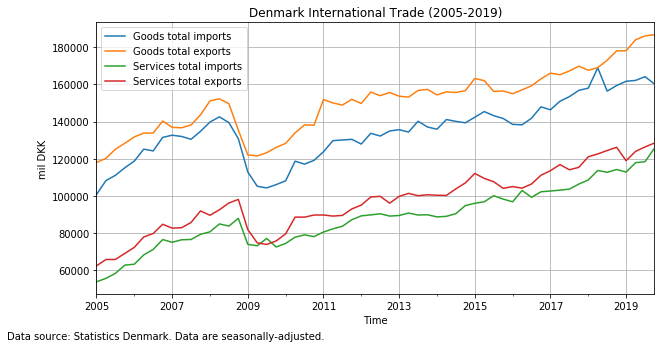

In [20]:
fig1 = int_tr1.plot(figsize=(10,5))
fig1.set_title('Denmark International Trade (2005-2019)')
txt1 = "Data source: Statistics Denmark. Data are seasonally-adjusted."
fig1.set_xlabel('Time')
fig1.set_ylabel('mil DKK')
fig1.legend(['Goods total imports', 'Goods total exports', 'Services total imports', 'Services total exports'], loc=2)
plt.figtext(0.001, 0.001, txt1, wrap=True, horizontalalignment='left', fontsize=10)
fig1.grid(True)
plt.show()

From the figure, we can easily notice that Denmark has a bigger exchange in volume of goods with in comparison to services. During the last 15 years for both goods and services the trend has been positive. The only oddity is represented by the year 2009 where both imports and exports have suffered a drastic collapse probably due to the great global recession. From the graph we can also deduct that the BOT for Denmark has been positive during the last 15 years. We are going to plot it as well:

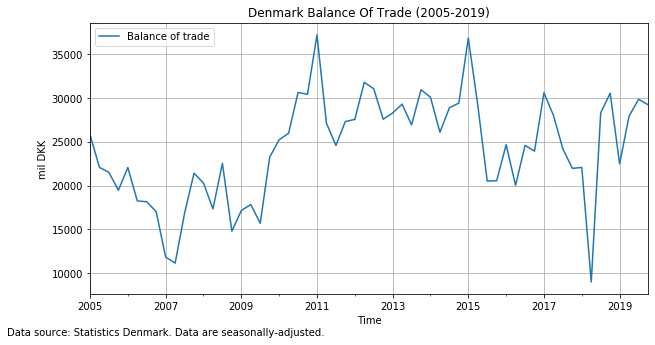

In [21]:
fig2 = int_tr2.plot( y = 'balance_of_trade', figsize=(10,5))
txt2 = "Data source: Statistics Denmark. Data are seasonally-adjusted."
fig2.set_title('Denmark Balance Of Trade (2005-2019)')
fig2.set_xlabel('Time')
fig2.set_ylabel('mil DKK')
fig2.legend(['Balance of trade'], loc=2)
plt.figtext(0.01, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)
fig2.grid(True)
plt.show()

The line illustrates the balance trade of Denmark over the 15 years period 2005-2019. The BOT amount has fluctuated during this period. In any case, Denmark seems to have never experience a significant deficit during this time. It reaches a peak in 2011 and 2015 of around 37000 mil Kr and the lowest amounts in 2007 and 2018. 

We now concentrate our attention in the trade market of goods. We plot the horizontal stacked bar chart which show the relative importance of every trade partner with respect to the overall export of goods.

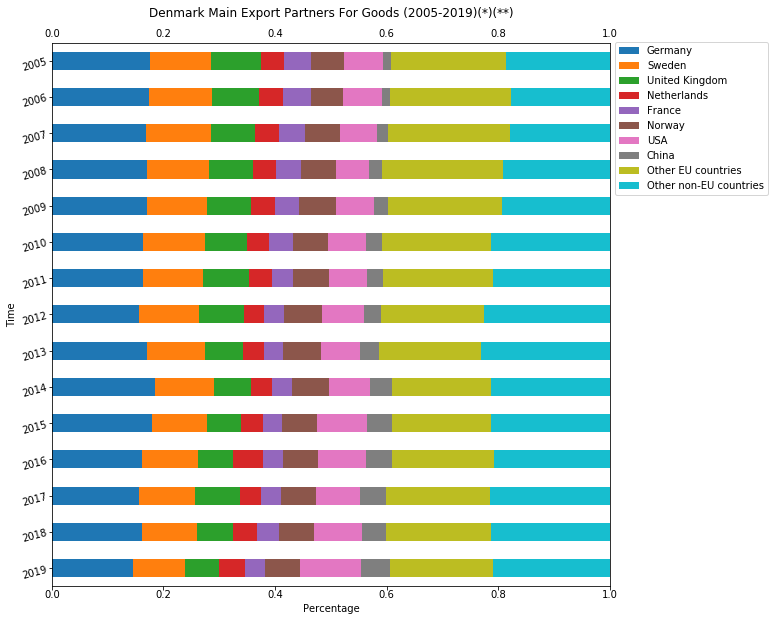

In [22]:
fig3 = tr3_perc.plot(figsize=(10,10), kind='barh', stacked=True, rot=15, )
plt.gca().invert_yaxis()
txt = "Data Source: Statistics Denmark. *Data seasonally-adjusted. **Excl. Vessels and Aircraft, Fuels."
fig3.tick_params(labeltop=True, labelright=False, pad = 0.1)
fig3.set_title('Denmark Main Export Partners For Goods (2005-2019)(*)(**)', pad = 12)
fig3.set_xlabel('Percentage')
fig3.set_ylabel('Time')
fig3.set_xlim(0,1)
fig3.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
txt = "Data Source: Statistics Denmark. *Data seasonally-adjusted. **Excl. Vessels and Aircraft, Fuels."
fig3.tick_params(labeltop=True, labelright=False)
fig3.grid(False)
plt.show(fig3)

From the graph above, Germany, Sweden and United Kingdom seem to be the most important european destinations for danish goods even if UK has slightly decreased its relative importance from 2005 to 2019. On overall, during the last 15 years, they have represented around 30% of overall exports value.   
Moreover, United States and China have grown their relative importance and they now count for more that 10% of the total exports of goods. Netherlands and France seems to play and mantain a marginal role while Norway remains a relevant trade partner if we take into consideration countries outside the European Union.  
Finally, it is important to underline that the remaining countries collected under the categories *Other EU countries* and *Other non-EU countries* are still the destination of around 40% of the danish goods exports. 

We now plot the horizontal stacked bar chart which show the relative importance of every trade partner with respect to the imports of goods

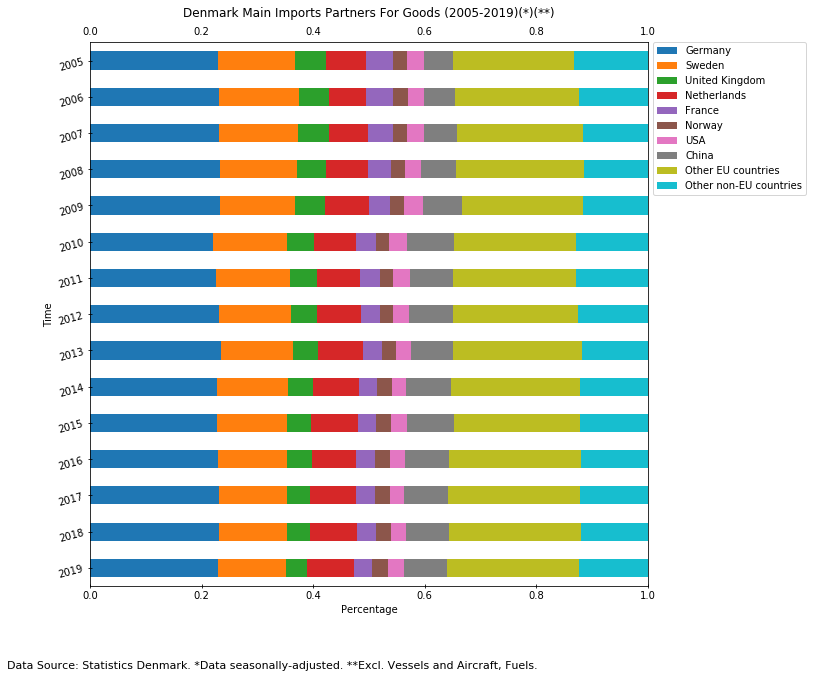

In [23]:
fig4 = trimp3_perc.plot(figsize=(10,10), kind='barh', stacked=True, rot=15, )
plt.gca().invert_yaxis()
txt = "Data Source: Statistics Denmark. *Data seasonally-adjusted. **Excl. Vessels and Aircraft, Fuels."
fig4.set_title('Denmark Main Imports Partners For Goods (2005-2019)(*)(**)', pad=10)
fig4.tick_params(direction = 'inout', labeltop=True, labelright=False)
fig4.set_xlabel('Percentage')
fig4.set_ylabel('Time')
fig4.set_xlim(0,1)
fig4.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
plt.figtext(0.01, 0.01, txt, wrap=True, horizontalalignment='left', fontsize=11)
fig4.grid(False)
plt.show(fig3)

Germany and Sweden are also confirmed to be relevant trading partners for Denmark regarding the imports of goods.   
Their relative importance has changed a little during the last 15 years representing around 35% of overall imports value.   
Great Britain, United States and Norway that represent outstanding export destinations are less relevant for the supply of goods. China and Netherlands, instead, seem to play a major role for imports in comparison to exports with the latter counting around 10% of the danish overall goods imports. Moreover, France mantains a marginal role also with respect to imports.  
The remaining countries collected under the categories *Other EU countries* and *Other non-EU countries* represent around 40% of the total imports value.   
Finally, we can notice that no major change has occured during the last 15 years and the composition of the market has remained basically the same. 

We now costruct the stacked bar chart and interactive pie chart to show the changes in composition of exports by type of goods during time.

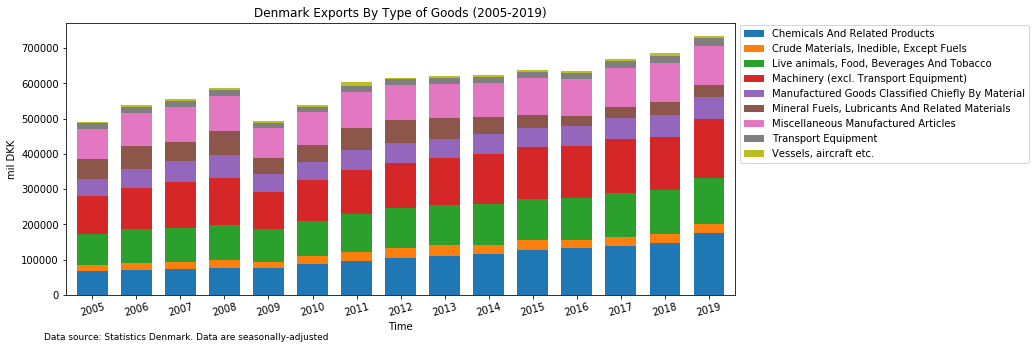

In [24]:
fig5 = gdr2.plot(figsize=(12,5), kind='bar', stacked=True, rot=15, width=0.7)
txt5 = "Data source: Statistics Denmark. Data are seasonally-adjusted "
fig5.set_title('Denmark Exports By Type of Goods (2005-2019)')
fig5.set_xlabel('Time')
fig5.set_ylabel('mil DKK')
fig5.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
plt.figtext(0.1, 0, txt5, wrap=True, horizontalalignment='left', fontsize=9)
fig5.grid(False)
plt.show()

In [25]:
gdr2_perc.index = gdr2_perc.index.to_series().astype(str)
gdr2_perc.index = gdr2_perc.index.to_series().astype(int)
gdr3_perc = gdr2_perc.copy()
gdr3_perc = gdr3_perc.reset_index()

def _plot_timeseries(df, years):
    fig = plt.figure(dpi=200) #Creating figure
    ax = fig.add_subplot(1,1,1)
    
    toplot= df[df['Date']==years][df.columns.difference(['Date'])]
    labels = df.columns[1:]
    explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
    ax.pie(toplot, autopct='%1.1f%%', textprops={'fontsize': 7}, labels = labels, explode = explode, shadow=True, startangle=140)
    
    ax.axis('equal')
def plot_time(df):
    widgets.interact(_plot_timeseries, 
    df = widgets.fixed(df),
    years = widgets.IntSlider(
        description='Year',
        min=2005,
        max=2019,
        value=2005,
        orientation='horizontal',
        continuous_update=False,
    )                 
);  
    
fig6 = plot_time(gdr3_perc)
fig6

interactive(children=(IntSlider(value=2005, continuous_update=False, description='Year', max=2019, min=2005), …

Fist of all, from the pie chart, we notice that the three main categories of goods exported in ***2005*** were, in order, *Machinery (excl. Transport Equipment)* (21,8%), *Live Animals, Food, Beverages and Tobacco* (17,7%) and *Miscellaneous Manufactured Articles* (17,4%). In ***2012*** they were *Machinery* (21,1%), *Animals, Food, Beverages and Tobacco* (18,1%) and *Chemicals* (17,1%) and in ***2019*** *Chemicals* (23.9%), *Machinery* (23.1%) and *Animals, Food, Beverages and Tobacco* (17.6%). This underlines the increasing importance that chemicals products have for the exports of the country and the relative stability of the *Machinery* and *food/Beverage* sectors during time, results confirmed by the stacked bar plot.  
The type of good that decreases the most in relative terms during the last 15 years is *Minerals Fuels, Lubricants and related materials*. It passes from 11.5% in ***2005*** to 4.4% in ***2019*** suggesting an underlying declining trend captured by the bar graph.
*Trasport equipment*, *Vessels, aircrats, etc* and *Crude Materials, Inedibles, Except Fuels* have always represented a very small fraction of danish exports while *miscellaneous manufactured articles* and *material goods* are responsible for around 25% of the country exports.

We now plot, instead, the stacked bar chart and the interactive pie chart regarding the imports by type of goods.

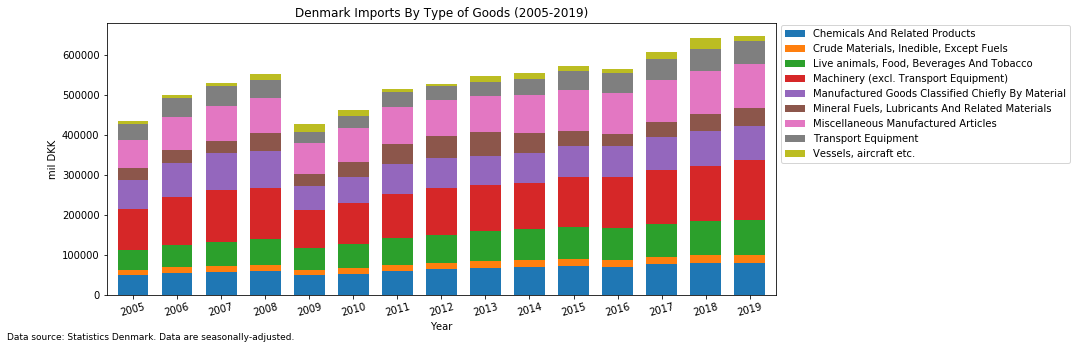

In [26]:
fig7 = fdr2.plot(figsize=(12,5), kind='bar', stacked=True, rot=15, width=0.7)
txt7 = "Data source: Statistics Denmark. Data are seasonally-adjusted."
fig7.set_title('Denmark Imports By Type of Goods (2005-2019)')
fig7.set_xlabel('Year')
fig7.set_ylabel('mil DKK')
fig7.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
plt.figtext(0.01, 0, txt7, wrap=True, horizontalalignment='left', fontsize=9)
fig7.grid(False)
plt.show()

In [27]:
fdr2_perc.index = fdr2_perc.index.to_series().astype(str)
fdr2_perc.index = fdr2_perc.index.to_series().astype(int)
fdr3_perc = fdr2_perc.copy()
fdr3_perc = fdr3_perc.reset_index() 
fig8 = plot_time(fdr3_perc)

interactive(children=(IntSlider(value=2005, continuous_update=False, description='Year', max=2019, min=2005), …

The first important thing we notice is that *Machinery (excl. Transport Equipment)* remains the most imported type of good regardless of the year that we take into consideration. It is followed by the sectors *Miscellaneous manufactured articles*, *Material goods* and *Live Animals, Food, Beverages and Tobacco* which constitute together around 45% of overall imports regardless of the year.   
*Mineral Fuels* and *Crude Materials* account on average for 10% of overall imports and *Vessels, Aircraft etc* always plays a marginal role.
An interesting fact is that *transport equipment* that it is not a relevant sector of export in Denmark counts for around 10% of overall imports.

## 4. Conclusion

In this project we analyzed imports and exports data from Statistics Denmark with a particular focus on the goods market. We showed that for both goods and services the trade trend has been positive suggesting increasing interaction of Denmark with the outside market for supply as well as for sales. The BOT has fluctuated during the last 15 years while mantaining a general surplus.  
The European Union countries prove to be important trading partners suggesting that the country has  greatly benefited from the common market. In particular, Germany and Sweden constitute the most important commercial partners suggesting that any internal shock to these two countries can have negative or positive effects for the Danish economy. Furthermore, the amount of relations with the United Kingdom hints that Brexit could have negative repercussions especially on the export side if trade is not properly regulated and protected. It is difficult to determine precisely what factors are driving the country's exports or imports whether, for example, a favorable exchange rate or the quality of the Danish industry's products. However, for example, we can rule out that the exchange rate pattern has influenced exports and imports with Germany as the krone is pegged to the euro at an exchange rate of around 7.46 since the 90's. However, the substantial immobility in the relative importance of every trade partner, in particular in the export market, suggests a good ability of Danish companies to maintain and build solid commercial relationships with their foreign counterparts over time.
In conclusion we looked at exports and imports by categories of goods. Regarding exports, we have seen an increase in the volumes and importance of *Chemicals and related products* with manufacturing products holding the second position. The primary sector has also played a non-negligible role with agricultural and related products accounting for about 20% of total exports. Regarding imports, instead, *Machinery*, *transport equipment* and *raw materials* are together the bulk of the country's imports followed by manufacturing and agricultural products.